In [1]:
import numpy as np
# get data
import os
import sys 
sys.path.append(os.path.abspath('..'))

from utils import create_directory
from model import test
from pathlib import Path
from tdr import *

In [5]:
data_dir = create_directory(directory_name='loss0_if') # loss0_if
model_num = 1
# pert - input fix [0,11,13]
# loss0_if - [2,3,7,13] 
model_name = "model{:02d}".format(model_num)


data = []
phases = ['NF1','FF1']
ff = [0,8]

for i,p in enumerate(phases):
    weight_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_weights'))[0]
    cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_cfg.json'))[0]
    data.append(test(cfg_file,weight_file,ff_coefficient=ff[i]))

In [6]:
# RUN TDR
Data_prep = get_data(data,phases,go_cue_idx=10)

beforeLearningN = Data_prep['Y'][0]
afterLearningN = Data_prep['Y'][1]



# Combine beforeLearningN and afterLearningN
combined_N = np.vstack((beforeLearningN, afterLearningN))

# Calculate the mean along axis 0 (mean of each neuron across conditions)
mean_N = np.mean(combined_N, axis=0)

# Center beforeLearningN and afterLearningN
beforeLearningN_center = beforeLearningN - mean_N
afterLearningN_center = afterLearningN - mean_N


before_learning_X = Data_prep['X_ldim'][0]
after_learning_X = Data_prep['X_ldim'][1]


betaNeural2Behav, betaNeural2BehavOrth, projectedStates = build_TDR_subspace(before_learning_X,beforeLearningN_center,
                                                                             after_learning_N=afterLearningN_center,
                                                                             after_learning_X=after_learning_X,
                                                                             TDR_options=1)

In [7]:
# Data_prep = get_data(data,phases,go_cue_idx=10)

# beforeLearningN = Data_prep['Y'][0]
# afterLearningN = Data_prep['Y'][1]

# x=np.mean(beforeLearningN, axis=0)
# y=np.mean(afterLearningN, axis=0)
# z=np.mean(np.vstack((beforeLearningN, afterLearningN)),axis=0)
# import matplotlib.pyplot as plt
# plt.plot(x)
# plt.plot(y)
# plt.plot(z)

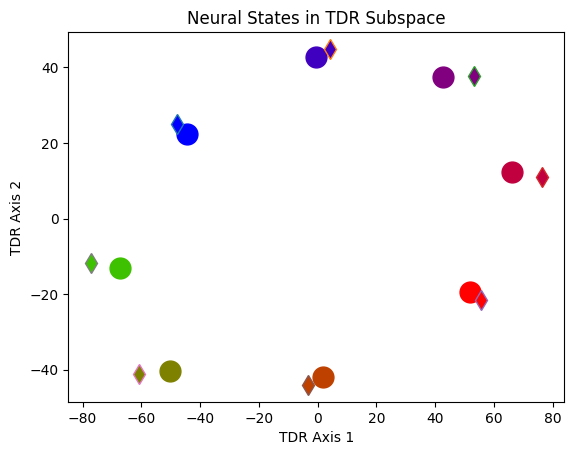

In [8]:
import matplotlib.pyplot as plt
import numpy as np

c1 = 0
c2 = 1

# Assuming projectedStates is your (8,2) matrix
n_cond = int(projectedStates.shape[0] / 2)


angle_set = np.deg2rad(np.arange(0, 360, 45))  # 8 directions
color_list = [plt.cm.brg(cond / (2 * np.pi)) for cond in angle_set]

# Create a scatter plot
plt.figure()
for i in range(n_cond):
    plt.plot(projectedStates[i, c1], projectedStates[i, c2], '.', markersize=30, color=color_list[i])
    plt.plot(projectedStates[i + n_cond, c1], projectedStates[i + n_cond, c2], 'd', markersize=10, markerfacecolor=color_list[i])

plt.xlabel('TDR Axis 1')
plt.ylabel('TDR Axis 2')
plt.title('Neural States in TDR Subspace')

plt.show()

In [9]:
# Assuming beforeLearningN_center and afterLearningN_center are your (C, N) matrices
# where C is the number of conditions, and N is the number of neurons

# Define the uniform-shift learning axis
uniformAxis = np.mean(afterLearningN_center, axis=0) - np.mean(beforeLearningN_center, axis=0)
uniformAxis = uniformAxis.reshape(-1, 1)

# Orthogonalize the uniform shift against the TDR axes
uniformAxisOrth = uniformAxis - np.dot(betaNeural2BehavOrth[:, 0], uniformAxis) / np.linalg.norm(betaNeural2BehavOrth[:, 0]) ** 2 * betaNeural2BehavOrth[:, 0]
uniformAxisOrth = uniformAxisOrth - np.dot(betaNeural2BehavOrth[:, 1], uniformAxisOrth) / np.linalg.norm(betaNeural2BehavOrth[:, 1]) ** 2 * betaNeural2BehavOrth[:, 1]

# Normalize the uniform shift axis
uniformAxisOrthNorm = uniformAxisOrth / np.linalg.norm(uniformAxisOrth)

# Project neural activity onto the uniform-shift axis
uniformStates = np.vstack((beforeLearningN_center, afterLearningN_center)) @ uniformAxisOrthNorm


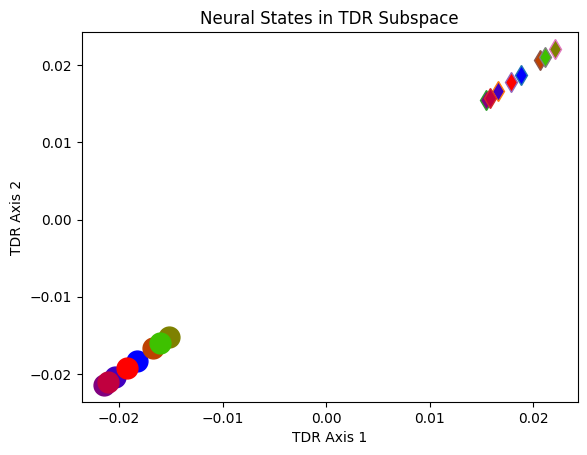

In [13]:
c1 = 0
c2 = 1

# Assuming projectedStates is your (8,2) matrix
n_cond = int(projectedStates.shape[0] / 2)


angle_set = np.deg2rad(np.arange(0, 360, 45))  # 8 directions
color_list = [plt.cm.brg(cond / (2 * np.pi)) for cond in angle_set]

# Create a scatter plot
plt.figure()
for i in range(n_cond):
    plt.plot(uniformStates[i, c1], uniformStates[i, c2], '.', markersize=30, color=color_list[i])
    plt.plot(uniformStates[i + n_cond, c1], uniformStates[i + n_cond, c2], 'd', markersize=10, markerfacecolor=color_list[i])

plt.xlabel('TDR Axis 1')
plt.ylabel('TDR Axis 2')
plt.title('Neural States in TDR Subspace')

plt.show()